In [1]:
using QEDFeynmanDiagrams
using ComputableDAGs
using RuntimeGeneratedFunctions
RuntimeGeneratedFunctions.init(@__MODULE__)
using QEDprocesses
using QEDcore
using DataFrames
using BenchmarkTools

In [2]:
N = 4
pair_prod_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), Positron()),
        (ntuple(_ -> Electron(), n)..., ntuple(_ -> Positron(), n)...),
        (SpinUp(), SpinUp()),
        (ntuple(_ -> SpinUp(), n)..., ntuple(_ -> SpinUp(), n)...),
    )

    graph_gen_bench = @benchmark generate_DAG($proc_nocombs)
    
    g_nocombs = generate_DAG(proc_nocombs)

    push!(pair_prod_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(graph_gen_bench.times), std(graph_gen_bench.times)))
end

pair_prod_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,38,41645.0,2.68901e5
2,36,238,1.26738e6,2.10254e5
3,1728,1402,5.39132e7,2.36085e6
4,158400,8959,2.51028e9,4.39484e6


In [3]:
N = 4
pair_prod_all_sp_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), Positron()),
        (ntuple(_ -> Electron(), n)..., ntuple(_ -> Positron(), n)...),
        (AllSpin(), AllSpin()),
        (ntuple(_ -> AllSpin(), 2*n)...,),
    )

    graph_gen_bench = @benchmark generate_DAG($proc_nocombs)
    
    g_nocombs = generate_DAG(proc_nocombs)

    push!(pair_prod_all_sp_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(graph_gen_bench.times), std(graph_gen_bench.times)))
end

pair_prod_all_sp_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,176,429656.0,2.1984e5
2,36,3316,2.1547e7,1.50837e6
3,1728,118312,1.40408e9,5.38489e7
4,158400,3786085,6.21097e10,NaN


In [4]:
include("../test/utils.jl")

using Random
RNG = MersenneTwister(21)

N = 2
pair_prod_exec_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), Positron()),
        (ntuple(_ -> Electron(), n)..., ntuple(_ -> Positron(), n)...),
        (SpinUp(), SpinUp()),
        (ntuple(_ -> SpinUp(), n)..., ntuple(_ -> SpinUp(), n)...),
    )

    g_nocombs = generate_DAG(proc_nocombs)

    func = get_compute_function(g_nocombs, proc_nocombs, cpu_st(), @__MODULE__)

    psp = gen_process_input(RNG, proc_nocombs)

    exec_bench = @benchmark $func($psp)

    push!(pair_prod_exec_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(exec_bench.times), std(exec_bench.times)))
end

pair_prod_exec_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,38,565.523,94.977
2,36,238,4888.0,1363.51


In [5]:
include("../test/utils.jl")

using Random
RNG = MersenneTwister(21)

N = 2
pair_prod_exec_all_combs_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_allcombs = ScatteringProcess(
        (Electron(), Positron()),
        (ntuple(_ -> Electron(), n)..., ntuple(_ -> Positron(), n)...),
        (AllSpin(), AllSpin()),
        (ntuple(_ -> AllSpin(), n)..., ntuple(_ -> AllSpin(), n)...),
    )

    g_allcombs = generate_DAG(proc_allcombs)

    func = get_compute_function(g_allcombs, proc_allcombs, cpu_st(), @__MODULE__)

    psp = gen_process_input(RNG, proc_allcombs)

    exec_bench = @benchmark $func($psp)

    push!(pair_prod_exec_all_combs_df, (length(feynman_diagrams(proc_allcombs)), length(g_allcombs.nodes), median(exec_bench.times), std(exec_bench.times)))
end

pair_prod_exec_all_combs_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,176,4063.57,753.026
2,36,3316,1.20006e5,17671.3


# Plotting

In [27]:
# Colors and Setup
using Plots
using StatsPlots
using CurveFit

color1 = parse(RGBA, "#FF1F5B")
color2 = parse(RGBA, "#009ADE")
color3 = parse(RGBA, "#AF58BA")

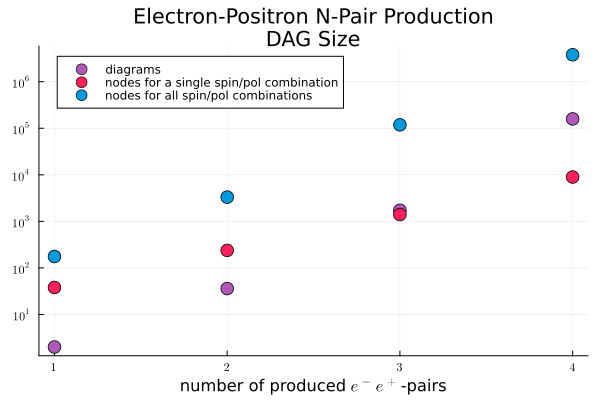

In [32]:
fig = scatter(
    [pair_prod_df.diagrams pair_prod_df.nodes pair_prod_all_sp_df.nodes],
    yscale=:log10,
    seriescolor=[color3 color1 color2],
    label=["diagrams" "nodes for a single spin/pol combination" "nodes for all spin/pol combinations"],
    title="Electron-Positron N-Pair Production\nDAG Size",
    #ylabel="#",
    xlabel="number of produced \$e^- e^+\$-pairs",
    markersize=7,
    legend_position=:topleft,
    #size=(600, 500),
    xticks=([1, 2, 3, 4], ["\$1\$", "\$2\$", "\$3\$", "\$4\$"]),
    yticks=([1e1, 1e2, 1e3, 1e4, 1e5, 1e6], ["\$10^1\$", "\$10^2\$", "\$10^3\$", "\$10^4\$", "\$10^5\$", "\$10^6\$"]),
)
savefig(fig, "pair_prod_dag_size.pdf")
fig

ExpFit{Float64}((1.0073547049700222, 0.9080933796268311))ExpFit{Float64}((0.18267537761058594, 1.6751821582691206))

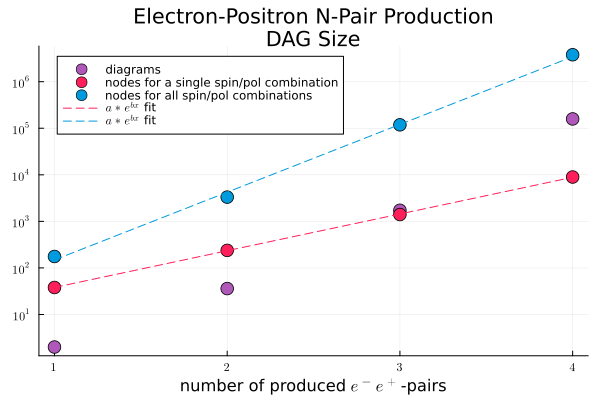

In [33]:
fig = scatter(
    [pair_prod_df.diagrams pair_prod_df.nodes pair_prod_all_sp_df.nodes],
    yscale=:log10,
    seriescolor=[color3 color1 color2],
    label=["diagrams" "nodes for a single spin/pol combination" "nodes for all spin/pol combinations"],
    title="Electron-Positron N-Pair Production\nDAG Size",
    #ylabel="#",
    xlabel="number of produced \$e^- e^+\$-pairs",
    markersize=7,
    legend_position=:topleft,
    #size=(600, 500),
    xticks=([1, 2, 3, 4], ["\$1\$", "\$2\$", "\$3\$", "\$4\$"]),
    yticks=([1e1, 1e2, 1e3, 1e4, 1e5, 1e6], ["\$10^1\$", "\$10^2\$", "\$10^3\$", "\$10^4\$", "\$10^5\$", "\$10^6\$"]),
)

f_nodes_single = curve_fit(ExpFit, Float64.(4:2:10), Float64.(pair_prod_df.nodes))
f_nodes_all = curve_fit(ExpFit, Float64.(4:2:10), Float64.(pair_prod_all_sp_df.nodes))

show(f_nodes_single)
show(f_nodes_all)

plot!(1:0.05:4, f_nodes_single.(4:0.10:10), seriescolor=color1, label = "\$a*e^{bx}\$ fit", linestyle=:dash)
plot!(1:0.05:4, f_nodes_all.(4:0.10:10), seriescolor=color2, label = "\$a*e^{bx}\$ fit", linestyle=:dash)
savefig(fig, "pair_prod_dag_sizes_expfit.pdf")
fig

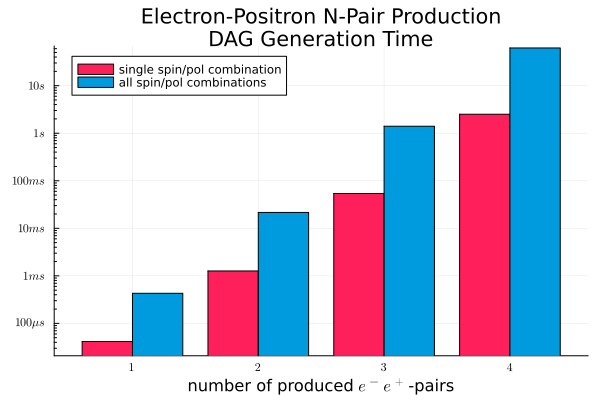

In [34]:
fig = groupedbar(
    ["\$1\$", "\$2\$", "\$3\$", "\$4\$"],
    [(pair_prod_df.t_med ./ 1e9) (pair_prod_all_sp_df.t_med ./ 1e9)],
    #yerr = [(compton_df.t_std ./ 1e9) (compton_all_sp_df.t_std ./ 1e9)],
    seriescolor=[color1 color2],
    title="Electron-Positron N-Pair Production\nDAG Generation Time",
    label=["single spin/pol combination" "all spin/pol combinations"],
    xlabel="number of produced \$e^- e^+\$-pairs",
    yticks=([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
        ["\$100μs\$", "\$1ms\$", "\$10ms\$", "\$100ms\$", "\$1s\$", "\$10s\$"]),
    yminorticks=true,
    yaxis=:log10, ylim=[0.5 * min(pair_prod_df.t_med...) / 1e9, 1.1 * max(pair_prod_all_sp_df.t_med...) / 1e9],
)
savefig(fig, "pair_prod_dag_gen_time.pdf")
fig

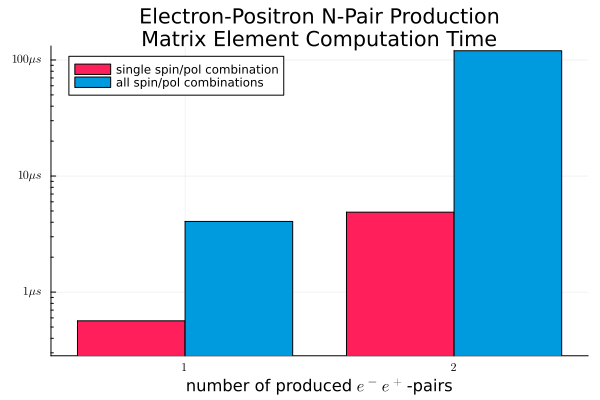

In [35]:
fig = groupedbar(
    ["\$1\$", "\$2\$"],
    [(pair_prod_exec_df.t_med[begin:2] ./ 1e9) (pair_prod_exec_all_combs_df.t_med[begin:2] ./ 1e9)],
    #yerr = [(compton_exec_df.t_std ./ 1e9) (compton_exec_all_combs_df.t_std ./ 1e9)],
    seriescolor=[color1 color2],
    title="Electron-Positron N-Pair Production\nMatrix Element Computation Time",
    label=["single spin/pol combination" "all spin/pol combinations"],
    xlabel="number of produced \$e^- e^+\$-pairs",
    yticks=([1e-6, 1e-5, 1e-4, 1e-3],
        ["\$1μs\$", "\$10μs\$", "\$100μs\$", "\$1ms\$"]),
    yminorticks=true,
    yaxis=:log10,
    ylim=[0.5 * min(pair_prod_exec_df.t_med[begin:2]...) / 1e9, 1.1 * max(pair_prod_exec_all_combs_df.t_med[begin:2]...) / 1e9],
)
savefig(fig, "pair_prod_exec_time.pdf")
fig